In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Download stopwords if not available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load Cleaned Data

df = pd.read_csv("/kaggle/input/clean-youtube/cleaned_youtube_data.csv")
print("✅ Cleaned Data Loaded Successfully!")
print("Shape:", df.shape)
df.head()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Cleaned Data Loaded Successfully!
Shape: (22658, 25)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,description,country,publish_hour,publish_day,publish_month,like_ratio,dislike_ratio,comment_ratio,engagement,is_trending
0,2kyS6SvSYSE,0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,...,SHANTELL'S CHANNEL - https://www.youtube.com/s...,USA,17,Monday,November,0.076869,0.003963,0.021318,0.098187,0
1,1ZAPwfrtAFY,0,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,"One year after the presidential election, John...",USA,7,Monday,November,0.040179,0.002541,0.005252,0.045431,1
2,5qpjK5DgCt4,0,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,USA,19,Sunday,November,0.045758,0.001673,0.002563,0.048321,1
3,puqaWrEC7tY,0,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,Today we find out if Link is a Nickelback amat...,USA,11,Monday,November,0.029641,0.001941,0.006253,0.035895,0
4,d380meD0W0M,0,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,I know it's been a while since we did this sho...,USA,18,Sunday,November,0.063097,0.000949,0.008359,0.071456,1


In [3]:

#Text Cleaning Function
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # keep alphabets only
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply cleaning to relevant text columns
df['title_clean'] = df['title'].apply(clean_text)
df['tags_clean'] = df['tags'].apply(clean_text)
df['desc_clean'] = df['description'].apply(clean_text)

print("Cleaned title, tags, and description text successfully!")


Cleaned title, tags, and description text successfully!


In [4]:
#Combine Text Fields

df['combined_text'] = (
    df['title_clean'] + " " +
    df['tags_clean'] + " " +
    df['desc_clean']
)

print("Combined text columns into one unified feature!")


Combined text columns into one unified feature!


In [5]:
# TF-IDF Vectorization

tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
X_text = tfidf.fit_transform(df['combined_text']).toarray()

print("TF-IDF Shape:", X_text.shape)


TF-IDF Shape: (22658, 3000)


In [6]:
#Numeric Feature Scaling

num_features = ['like_ratio', 'dislike_ratio', 'comment_ratio', 'engagement', 'publish_hour']
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_features])

print("Numeric Features Shape:", X_num.shape)


Numeric Features Shape: (22658, 5)


In [7]:
# Step 7: Combine All Features

X = np.hstack((X_text, X_num))
y = df['is_trending']

print("Final Feature Matrix:", X.shape)
print("Target Vector:", y.shape)


Final Feature Matrix: (22658, 3005)
Target Vector: (22658,)


In [8]:
# Save Processed Data

np.save("/kaggle/working/X_features.npy", X)
np.save("/kaggle/working/y_labels.npy", y)

# Save vectorizer & scaler for model + dashboard
with open("/kaggle/working/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open("/kaggle/working/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Saved features and transformers successfully!")


Saved features and transformers successfully!


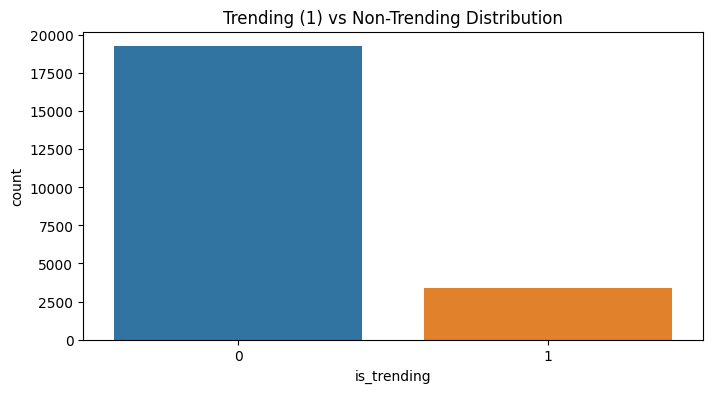

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


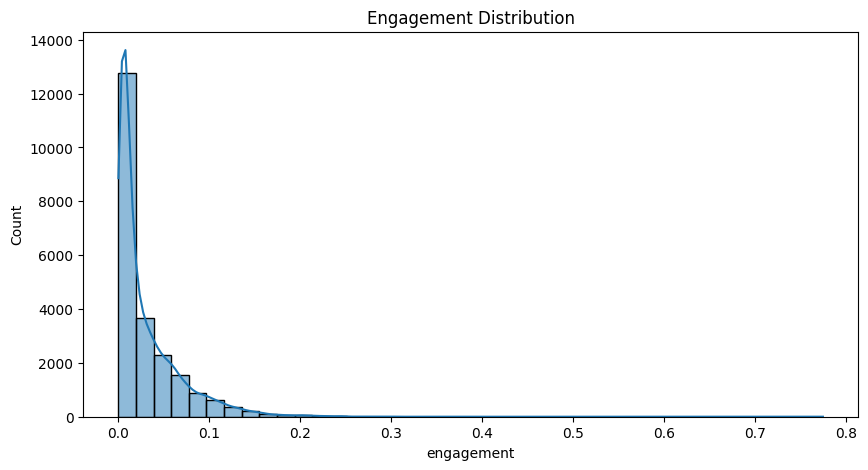

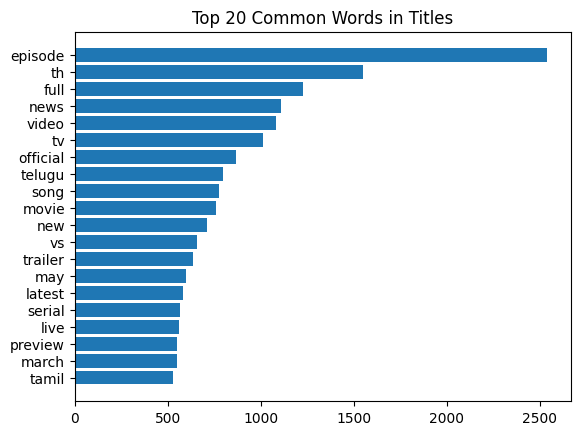

In [9]:
# Step 9: Insights Visualization

plt.figure(figsize=(8,4))
sns.countplot(x='is_trending', data=df)
plt.title("Trending (1) vs Non-Trending Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['engagement'], kde=True, bins=40)
plt.title("Engagement Distribution")
plt.show()

# Word Frequency Example
from collections import Counter
word_freq = Counter(" ".join(df['title_clean']).split()).most_common(20)
plt.barh([w[0] for w in word_freq[::-1]], [w[1] for w in word_freq[::-1]])
plt.title("Top 20 Common Words in Titles")
plt.show()
